# Concentration function with exponential crosswind and no reflection term

In [2]:
#%matplotlib widget
import flux_model as fm 
import flux_plots as fp
import numpy as np
import matplotlib.pyplot as plt


# Concentration Function and Equations

The concentration of pollutants at a point \\((x, y, z)\\) is given by:

\begin{aligned}
C(x, y, z) =\ & \frac{q}{2 \pi u \left( \dfrac{x}{1000} \right) \sigma_y \cdot \sigma_z }
& \times \left[ \exp\left( -\dfrac{ (z - h)^2 }{ 2 \sigma_z^2 } \right) + \exp\left( -\dfrac{ (z + h)^2 }{ 2 \sigma_z^2 } \right) \right] \times \exp\left( -\dfrac{ y^2 }{ 2 \sigma_y^2 } \right)
\end{aligned}


## Explanation of Each Term

- **$C(x, y, z)$**: Concentration of the pollutant at point $(x, y, z)$ in grams per cubic meter (**g/m³**).

- **$q$**: Emission rate of the pollutant source in grams per second (**g/s**).

- **$u$**: Wind speed at the source height in meters per second (**m/s**).

- **$(a_{\text{case}}, b_{\text{case}}, c_{\text{case}}, d_{\text{case}})$**: Empirical coefficients depending on the Pasquill-Giffard atmospheric stability class (more on this later).

- **$h$**: Source height (**m**).

- **$x$**: Downwind distance from the source in meters (**m**), converted to kilometers by dividing by 1000.

- **$y$**: Crosswind distance from the centerline of the plume in meters (**m**).

- **$z$**: Vertical distance above ground level in meters (**m**).


(<Figure size 1200x800 with 2 Axes>,
 <Axes3D: title={'center': 'Concentration Field at Height z ≈ 10 m'}, xlabel='Downwind Distance x (m)', ylabel='Crosswind Distance y (m)', zlabel='Concentration (g/m³)'>)

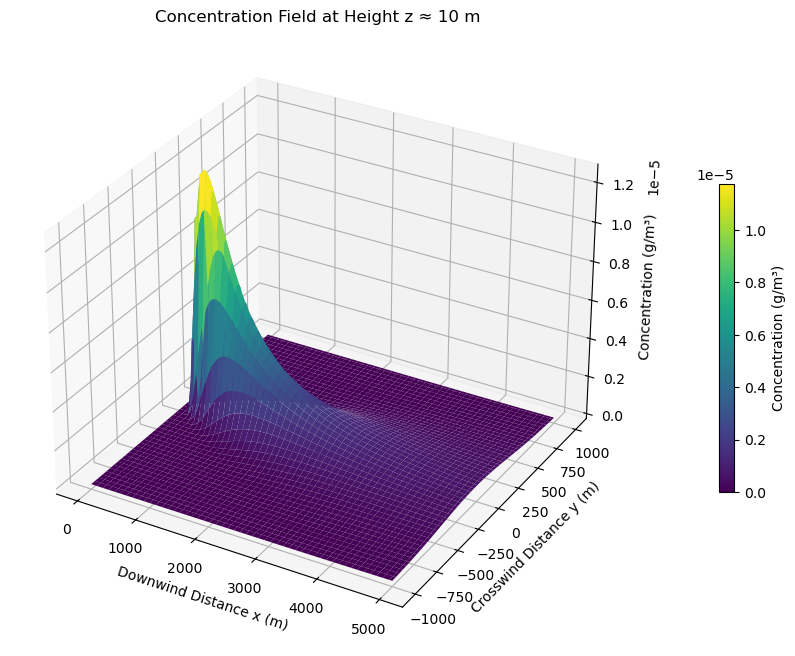

In [3]:
# Parameters
q = 1.0      # Emission rate in grams per second
u = 5.0       # Wind speed in meters per second
h = 50.0      # Effective stack height in meters
ls = 1000.0    # Source width in meters
case = 2     # Atmospheric stability class (0-based index, from 0 to 5)

# Create the coordinate grids
x = np.linspace(0, 5000, 100)
y = np.linspace(-1000, 1000, 100)
z = np.linspace(0, 700, 50)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Compute the concentration data
concentration = fm.conc_point(q, u, X, Y, Z, h, case)

#fp.plot_isosurfaces(X, Y, Z, concentration, cmap='viridis')
fp.plot_concentration_surface(X, Y, Z, concentration, z_level=10)

# Dispersion

## Vertical Dispersion Term:

  $\exp\left( -\dfrac{ (z - h)^2 }{ 2 \sigma_z^2 } \right) + \exp\left( -\dfrac{ (z + h)^2 }{ 2 \sigma_z^2 } \right)$

  - Models the vertical spread of the plume, including reflection at the ground.

  $\sigma_z = a_{\text{case}} \left( \frac{x}{1000} \right)^{b_{\text{case}}}$

## Crosswind Dispersion Term

  $\exp\left( -\dfrac{ y^2 }{ 2 \sigma_y^2 } \right)$

  - Models the horizontal spread of the plume in the crosswind direction.

  $\sigma_y = 465.11628 \left( \frac{x}{1000} \right) \tan\left( \theta \right)$

  Where:

  $\theta = 0.017453293 \left( c_{\text{case}} - d_{\text{case}} \ln\left( \frac{x}{1000} \right) \right)$

  - **$0.017453293$**: Conversion factor from degrees to radians ($ \frac{\pi}{180} \approx 0.017453293 $).

[170.  98.  61.  32.  21.  14.] [1.09 0.98 0.91 0.81 0.75 0.68] [24. 18. 12.  8.  6.  4.] [2.5  1.8  1.1  0.72 0.54 0.36]


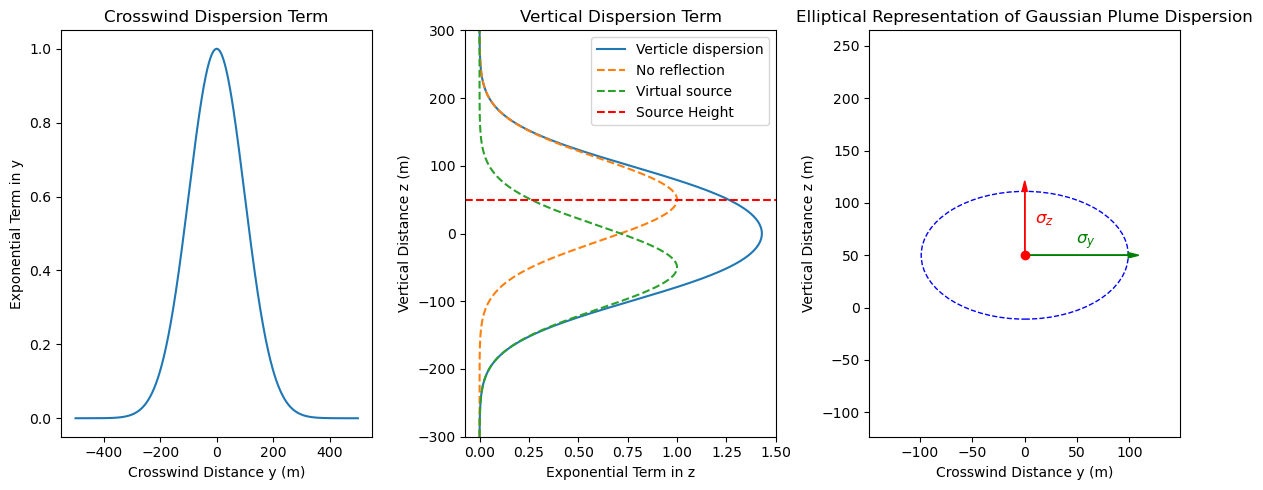

In [4]:
a = np.array([170.0, 98.0, 61.0, 32.0, 21.0, 14.0])
b = np.array([1.09, 0.98, 0.91, 0.81, 0.75, 0.68])
c = np.array([24.0, 18.0, 12.0, 8.0, 6.0, 4.0])
d = np.array([2.5, 1.8, 1.1, 0.72, 0.54, 0.36])

# Parameters
q = 1000.0  # Emission rate (grams per second)
u = 5.0     # Wind speed (meters per second)
x = 1000.0  # Downwind distance (meters)
h = 50.0    # Effective stack height (meters)
case = 2    # Atmospheric stability class index (0-based, e.g., 2 for Class C)

# Convert x to kilometers
x_km = x / 1000.0

# Retrieve parameters for the given case
c_case = c[case]
d_case = d[case]
a_case = a[case]
b_case = b[case]

# Calculate the angle in degrees and then convert to radians
angle_deg = c_case - d_case * np.log(x_km)
angle_rad = np.radians(angle_deg)

# Calculate the tangent term
tan_term = np.tan(angle_rad)

# Constants
constant = 465.11628

# Calculate dispersion parameters
sigma_z = a_case * x_km ** b_case
sigma_y = constant * x_km * tan_term

# Create arrays for y and z
y = np.linspace(-500, 500, 1000)  # Crosswind distances (meters)
z = np.linspace(-300, 300, 1000)     # Vertical distances (meters)

# Compute exponential terms
exp_y = np.exp(-y ** 2 / (2 * sigma_y ** 2))
exp_z = np.exp(-((z - h) ** 2) / (2 * sigma_z ** 2)) + np.exp(-((z + h) ** 2) / (2 * sigma_z ** 2))
exp_z_virtual = np.exp(-((z + h) ** 2) / (2 * sigma_z ** 2))
exp_z_reflection = np.exp(-((z - h) ** 2) / (2 * sigma_z ** 2)) 

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

# Plot exp_y vs y
ax1.plot(y, exp_y)
ax1.set_title('Crosswind Dispersion Term')
ax1.set_xlabel('Crosswind Distance y (m)')
ax1.set_ylabel('Exponential Term in y')

# Plot exp_z vs z
ax2.plot(exp_z, z, label='Verticle dispersion')
ax2.plot(exp_z_reflection, z, linestyle='--', label='No reflection')
ax2.plot(exp_z_virtual, z, linestyle='--', label='Virtual source')
ax2.set_title('Vertical Dispersion Term')
ax2.set_xlabel('Exponential Term in z')
ax2.set_ylabel('Vertical Distance z (m)')
ax2.set_ylim(-300, 300)
# Add a horizontal dashed red line at the source height
ax2.axhline(y=h, color='red', linestyle='--', label='Source Height')

# Add legend to ax2
ax2.legend()

ax3 = fp.plot_dispersion_ellipse(x, h, case, ax=ax3)

plt.tight_layout()
plt.show()

(<Figure size 1200x800 with 1 Axes>,
 <Axes3D: title={'center': 'Isosurfaces of Pollutant Concentration'}, xlabel='Downwind Distance x (m)', ylabel='Crosswind Distance y (m)', zlabel='Height z (m)'>)

/Applications/miniconda3/envs/gaussian_mixing/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Applications/miniconda3/envs/gaussian_mixing/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


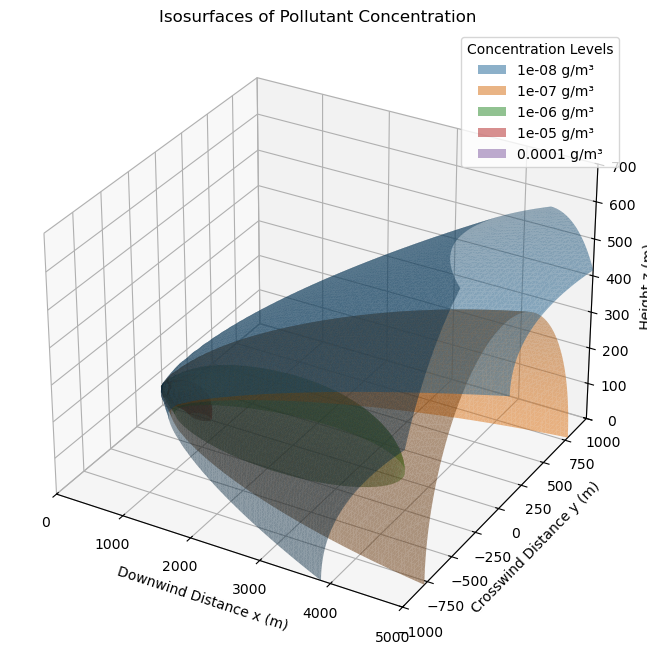

In [5]:
fp.plot_isosurfaces(X, Y, Z, concentration, iso_concentrations=[1e-8, 1e-7, 1e-6, 1e-5, 1e-4])

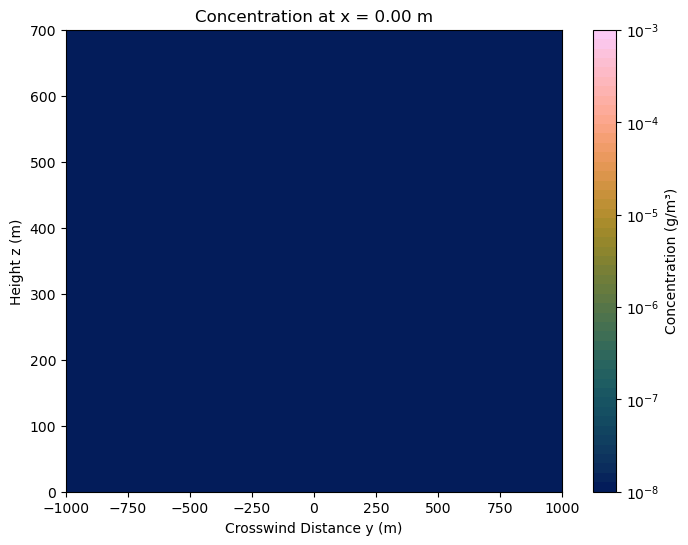

interactive(children=(IntSlider(value=0, description='x_index', max=99), Output()), _dom_classes=('widget-inte…

In [6]:

# Call the interactive plotting function
fig, ax = fp.plot_concentration_contours_yz_plane_interactive(X, Y, Z, concentration)
